In [0]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import linear_kernel
import scipy.sparse as sp
import scipy.linalg as sparcyLinalg
from collections import Counter

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [0]:
BASE_DIR = '/content/drive/My Drive/tfidf_cosine/'

In [0]:
DATASETS_PATH = BASE_DIR

In [0]:
def load_data(filename_train, filename_test, filename_val):
    """
    Load train, test and validation sets from file

    Args:
        filename_train : Name of the file from which the train data is to be loaded
        filename_test : Name of the file from which the test data is to be loaded
        filename_val : Name of the file from which the validation data is to be loaded
    
    Returns:
        train_tweet_X: list of tweets from train data
        train_tweet_Y: list of lables correponding to each tweet from train data
        test_tweet_X: list of tweets from test data
        test_tweet_Y: list of lables correponding to each tweet from test data
        val_tweet_X: list of tweets from validation data
        val_tweet_Y: list of lables correponding to each tweet from validation data
    """
    train = pd.read_csv(filename_train)
    test = pd.read_csv(filename_test)
    val = pd.read_csv(filename_val)
    
    return train['Text'].tolist(), train['Label'].tolist(), test['Text'].tolist(), test['Label'].tolist(), val['Text'].tolist(), val['Label'].tolist()

In [7]:
# LOADING TRAIN, TEST AND VALIDATION SETS

train_tweet_X, train_tweet_Y, test_tweet_X, test_tweet_Y, val_tweet_X, val_tweet_Y = load_data(DATASETS_PATH + 'train.csv', DATASETS_PATH + 'test.csv', DATASETS_PATH + 'val.csv')

print("Train length: \t", len(train_tweet_X))
print("Test length: \t", len(test_tweet_X))
print("Val length: \t", len(val_tweet_X))

Train length: 	 40231
Test length: 	 11833
Val length: 	 7100


In [0]:
def preprocessing(tweets):
    """
    Perform preprocessing of the tweets

    Args:
        tweets : list of tweets
    
    Returns:
        result: preprocessed list of tweets
    """
    #set of stopwords
    stop_words = set(stopwords.words('english'))
    
    result = []
    for tweet in tweets:
        
        #tokenizing each tweet
        tokens = word_tokenize(tweet)
        
        #removing stopwords
        stopwords_removed_tokens = []
        for word in tokens:
            if word not in stop_words:
                stopwords_removed_tokens.append(word)
        
        result.append(stopwords_removed_tokens)
    
    return result

In [0]:
# PREPROCESSING TRAIN, TEST AND VALIDATION TWEETS

train_tweet_X = preprocessing(train_tweet_X)
test_tweet_X = preprocessing(test_tweet_X)
val_tweet_X = preprocessing(val_tweet_X)

In [0]:
#COMBINING TRAIN AND TEST TWEETS FOR CREATING TFIDF MATRIX

combined_tweets_X = []
for tweet in train_tweet_X:
    combined_tweets_X.append(tweet)
for tweet in test_tweet_X:
    combined_tweets_X.append(tweet)

combined_Y = []
for label in train_tweet_Y:
    combined_Y.append(label)
for label in test_tweet_Y:
    combined_Y.append('UNKNOWN')

actual_combined_Y = []
for label in train_tweet_Y:
    actual_combined_Y.append(label)
for label in test_tweet_Y:
    actual_combined_Y.append(label)

In [0]:
# TFIDF VECTORIZER (TRY USING NGRAM OPTION IN VECTORIZER AS WELL)

# Helper function
def do_nothing(x):
    return x

def create_features(combined_tweets_X, combined_Y, actual_combined_Y, test_tweet_Y):
    
    tfidf = TfidfVectorizer(analyzer='word', tokenizer=do_nothing, preprocessor=do_nothing, token_pattern=None)
    
    combined_Y = np.array(combined_Y)
    actual_combined_Y = np.array(actual_combined_Y)
    test_tweet_Y = np.array(test_tweet_Y)
    combined_tweets_X = tfidf.fit_transform(combined_tweets_X)
#     test_tweet_X = tfidf.transform(test_tweet_X)

    return (combined_tweets_X, combined_Y, actual_combined_Y, test_tweet_Y)

In [0]:
combined_tweets_X, combined_Y, actual_combined_Y, test_tweet_Y = create_features(combined_tweets_X, combined_Y, actual_combined_Y, test_tweet_Y)

In [0]:
def find_similar(tfidf_matrix, index, top_n = 10):
    cosine_similarities = linear_kernel(tfidf_matrix[index:index+1], tfidf_matrix).flatten()
    related_docs_indices = [i for i in cosine_similarities.argsort()[::-1] if i != index]
    return [(index, cosine_similarities[index]) for index in related_docs_indices][0:top_n]

In [0]:
all_similarities = []
for i in range(len(train_tweet_X), len(actual_combined_Y)):
  X = find_similar(combined_tweets_X, i)
  all_similarities.append(X)

In [0]:
def most_frequent(my_list): 
    occurence_count = Counter(my_list) 
    return occurence_count.most_common(1)[0][0] 

In [0]:
predictions = []
for index, x in enumerate(all_similarities):
  preds = []
  for i in x:
    preds.append(actual_combined_Y[i[0]])
  predictions.append(most_frequent(preds))

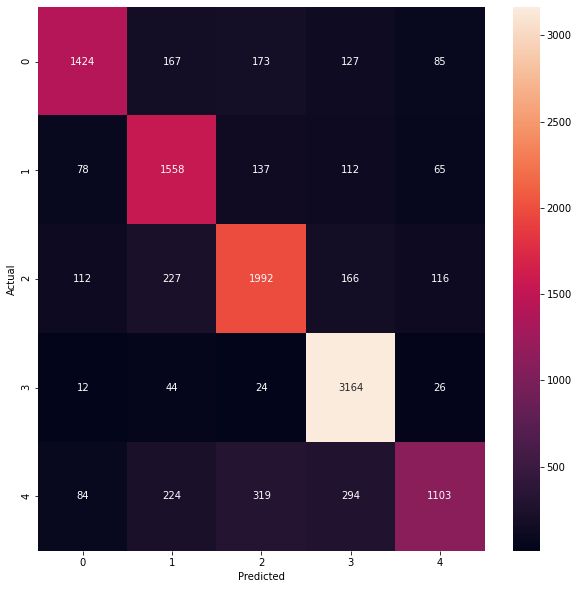

In [57]:
# Plotting Confusion Matrix

conf_mat = confusion_matrix(test_tweet_Y, predictions)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=['0', '1', '2', '3', '4'], yticklabels=['0', '1', '2', '3', '4'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [58]:
print(classification_report(test_tweet_Y, predictions))

               precision    recall  f1-score   support

fawadchaudhry       0.83      0.72      0.77      1976
maryamnsharif       0.70      0.80      0.75      1950
 mjibrannasir       0.75      0.76      0.76      2613
 narendramodi       0.82      0.97      0.89      3270
 sherryrehman       0.79      0.54      0.65      2024

     accuracy                           0.78     11833
    macro avg       0.78      0.76      0.76     11833
 weighted avg       0.78      0.78      0.78     11833

